In [128]:
%matplotlib inline

import os
import pandas as pd
import re

min_votes_ratings = 200

books_path = os.path.join("datasets", "books", "goodreads_books.csv")
books = pd.read_csv(books_path)

def pick_genre(genre_and_votes, level):
    if not isinstance (genre_and_votes, str):
        return ''
    gavs = genre_and_votes.split(', ')
    categories = []
    for gav in gavs:
        gavl = re.split('\s(?=[0-9])', gav)
        if len(gavl) != 2:
            continue
        genre, votes = gavl
        categories.append(genre.strip())
    if len(categories) >= level + 1:
        return categories[level]
    return ''
    
books['main_genre'] = books['genre_and_votes'].apply(
    lambda x: pick_genre(x, 0)
)
books['second_genre'] = books['genre_and_votes'].apply(
    lambda x: pick_genre(x, 1)
)

In [132]:

def filter_by_genre(genre, books, level):
    return books\
        .loc[books[level] == genre, :]\
        .loc[books.rating_count.astype(int) > min_votes_ratings, :]        

def filter_by_genres(books, level, min_books_category):
    genres = pd.DataFrame(books[level].str.extractall('([^0-9,]+)')).reset_index()
    genres = pd.DataFrame(pd.Series(genres[0].str.strip()).value_counts())
    genres = genres.loc[genres[0] > min_books_category, :]
    genres['mean'] = genres.index
    genres['std'] = genres.index

    genres['pop'] =  genres['mean'].apply(
        lambda x: filter_by_genre(x, books, level).shape[0]
    )
    genres['mean'] = genres['mean'].apply(
        lambda x: filter_by_genre(x, books, level).average_rating.mean()
    )
    genres['std'] = genres['std'].apply(
        lambda x: filter_by_genre(x, books, level).average_rating.std()
    )
    genres['ci'] = 2.57 * (genres['std']/(genres['pop']**(1/2))) # 2.57 = 99%
    return genres.sort_values(by='mean', ascending=False).reset_index()

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def print_errorbars(genres, h):
    plt.rcParams["figure.figsize"] = [7, h]
    plt.rcParams["figure.autolayout"] = True

    plt.errorbar(genres['mean'], genres.index, xerr=genres['ci'], yerr=0,
                   linestyle='None', c='gray', fmt='.')
    plt.errorbar(genres['fantasy_mean'], genres.index, xerr=genres['fantasy_ci'], yerr=0,
                   linestyle='None', c='blue', fmt='.')    
    plt.yticks(genres.index, labels=genres['index'])
    plt.axes().xaxis.grid(b=True, which='major', color='#666666', linestyle='-')

    plt.show()



In [138]:
genres = filter_by_genres(books, 'main_genre', 100)

<ipython-input-137-0ab55629354b>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.grid(b=True, which='major', color='#666666', linestyle='-')


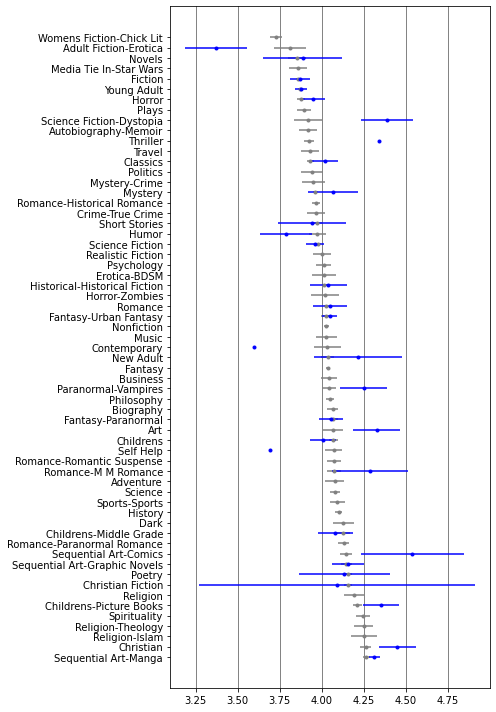

In [142]:
# if some genres are actualy better than others then even when they come as secondary genre 
# they should still respect the delta in ranking (eg: since Fantasy is better than Romance, Romance Fantasy books rating 
# should be higher than the overall Romance average).


def filter_second_genre(books, genre, ref):
    m = filter_by_genre(genre, books, 'main_genre')
    s = filter_by_genre(ref, m, 'second_genre')
    return s

genres['name'] = genres['index']

genres['fantasy_pop'] = genres['name'].apply(
    lambda x: filter_second_genre(books, x, 'Fantasy').shape[0]
)
genres['fantasy_mean'] = genres['name'].apply(
    lambda x: filter_second_genre(books, x, 'Fantasy').average_rating.mean()
)
genres['fantasy_std'] = genres['name'].apply(
    lambda x: filter_second_genre(books, x, 'Fantasy').average_rating.std()
)
genres['fantasy_ci'] = 2.57 * (genres['fantasy_std']/(genres['fantasy_pop']**(1/2))) # 2.57 = 99%


print_errorbars(genres, 10)
